In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import sys
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz
import arviz as az

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [3]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
n_chains = 4
chains = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=100, nskip=300, n_trees=100, proposal_probs=proposal_probs, multi_tries=[10,5,3], random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 400/400 [04:45<00:00,  1.40it/s]


Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.419


MultiGrow ratio count: 10121
MultiPrune ratio count: 9824
MultiChange ratio count: 15484
MultiSwap ratio count: 3348


C:\Windows\Temp\ipykernel_9196\3590833088.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


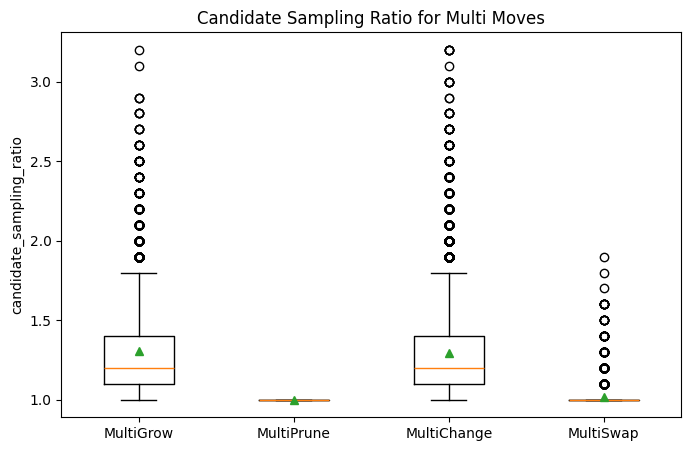

In [5]:
import matplotlib.pyplot as plt

# Collect ratios for all four Multi moves
grow_ratios = np.array(bart.sampler.multi_ratios["multigrow"])
prune_ratios = np.array(bart.sampler.multi_ratios["multiprune"])
change_ratios = np.array(bart.sampler.multi_ratios["multichange"])
swap_ratios = np.array(bart.sampler.multi_ratios["multiswap"])

# Print the number of samples for each move
print(f"MultiGrow ratio count: {len(grow_ratios)}")
print(f"MultiPrune ratio count: {len(prune_ratios)}")
print(f"MultiChange ratio count: {len(change_ratios)}")
print(f"MultiSwap ratio count: {len(swap_ratios)}")

# Combine for boxplot
data = [grow_ratios, prune_ratios, change_ratios, swap_ratios]
labels = ["MultiGrow", "MultiPrune", "MultiChange", "MultiSwap"]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=labels, showmeans=True)
plt.ylabel("candidate_sampling_ratio")
plt.title("Candidate Sampling Ratio for Multi Moves")
plt.show()

In [6]:
import pandas as pd

# Collect move counts
selected = bart.sampler.move_selected_counts
success = bart.sampler.move_success_counts
accepted = bart.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

              selected  success  accepted  success_rate  mh_ratio  accept_rate
multi_grow       10121    10121      6810      1.000000  0.672858     0.672858
multi_prune      10081     9824      6161      0.974506  0.627138     0.611150
multi_change     15943    15484      7921      0.971210  0.511560     0.496832
multi_swap        3855     3348      1765      0.868482  0.527180     0.457847


In [7]:
rf = RandomForestRegressor(random_state=42)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=100, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-07-16 22:41:22,183:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-07-16 22:41:22,188:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.12 A_prune=0.19 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.14 A_prune=0.18
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.07 A_prune=0.28


## Default BART

In [8]:
n_chains = 4
chains = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=100, nskip=300, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    chains.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 400/400 [00:16<00:00, 23.55it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.336


In [9]:
import pandas as pd

# Collect move counts
selected = bart_default.sampler.move_selected_counts
success = bart_default.sampler.move_success_counts
accepted = bart_default.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

        selected  success  accepted  success_rate  mh_ratio  accept_rate
grow        9966     9966      1898      1.000000  0.190448     0.190448
prune       9948     9752      1531      0.980298  0.156993     0.153900
change     16053    15717       975      0.979069  0.062035     0.060736
swap        4033     3119       459      0.773370  0.147163     0.113811


In [10]:
models = {"bart_mtmh": bart,
          "bart_default" : bart_default, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart_mtmh': 0.2182595767226468,
 'bart_default': 0.2456425688718318,
 'rf': 0.25424371393528344,
 'lr': 0.5411287478470689,
 'btz': 0.30284714582884426}